In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# reference：https://github.com/megvii-research/PMRID

class RawUtils:

    @classmethod
    def bggr2rggb(cls, *bayers):
        res = []
        for bayer in bayers:
            res.append(bayer[::-1, ::-1])
        if len(res) == 1:
            return res[0]
        return res

    @classmethod
    def rggb2bggr(cls, *bayers):
        return cls.bggr2rggb(*bayers)

    @classmethod
    def bayer2rggb(cls, *bayers):
        res = []
        for bayer in bayers:
            H, W = bayer.shape
            res.append(
                bayer.reshape(H//2, 2, W//2, 2)
                .transpose(0, 2, 1, 3)
                .reshape(H//2, W//2, 4)
            )
        if len(res) == 1:
            return res[0]
        return res

    @classmethod
    def rggb2bayer(cls, *rggbs):
        res = []
        for rggb in rggbs:
            H, W, _ = rggb.shape
            res.append(
                rggb.reshape(H, W, 2, 2)
                .transpose(0, 2, 1, 3)
                .reshape(H*2, W*2)
            )

        if len(res) == 1:
            return res[0]
        return res

    @classmethod
    def bayer2rgb(cls, *bayer_01s, wb_gain, CCM, gamma=2.2):

        wb_gain = np.array(wb_gain)[[0, 1, 1, 2]]
        res = []
        for bayer_01 in bayer_01s:
            bayer = cls.rggb2bayer((cls.bayer2rggb(bayer_01) * wb_gain).clip(0, 1)).astype(np.float32)
            bayer = np.round(np.ascontiguousarray(bayer) * 65535).clip(0, 65535).astype(np.uint16)
            rgb = cv2.cvtColor(bayer, cv2.COLOR_BAYER_BG2RGB_EA).astype(np.float32) / 65535
            rgb = rgb.dot(np.array(CCM).T).clip(0, 1)
            rgb = rgb ** (1/gamma)
            res.append(rgb.astype(np.float32))

        if len(res) == 1:
            return res[0]
        return res


# vim: ts=4 sw=4 sts=4 expandtab

In [3]:
def noise_model(input_array, k, sigma2):

    output = k * np.random.poisson(input_array / k) + np.random.normal(0, np.sqrt(sigma2), input_array.shape)
    output = np.clip(output, 0, 16383)

    return output

In [ ]:
path = './images/10106_00_30s.arw'

# The following data was obtained by dcraw(https://github.com/6by9/dcraw)
width=4288
height=2848
wb_dcraw = [2.542969, 1.0, 2.136719]
CCM_dcraw = [[1.971211, -0.678919, -0.292292], [-0.291040, 1.748361, -0.457321], [0.020513, -0.538073, 1.517560]]

In [5]:
with open(path, 'rb') as f:
    meta_offset = len(f.read())-width*height*2
    raw = np.fromfile(path, dtype=np.uint16, offset=meta_offset)
    raw = raw.reshape(height,width)

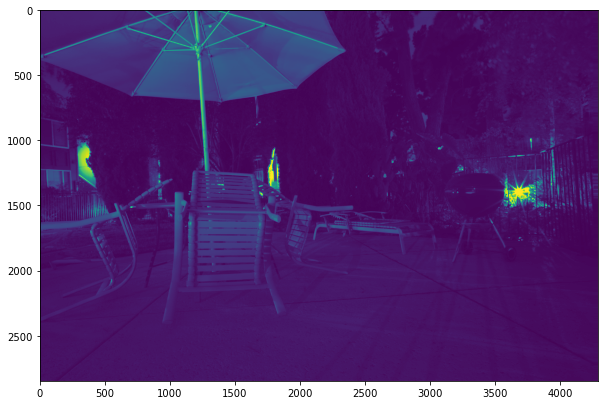

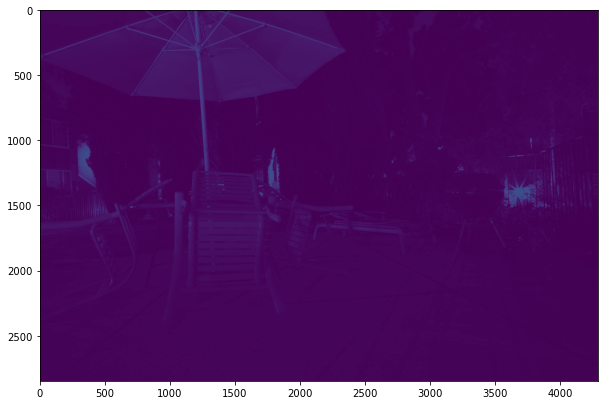

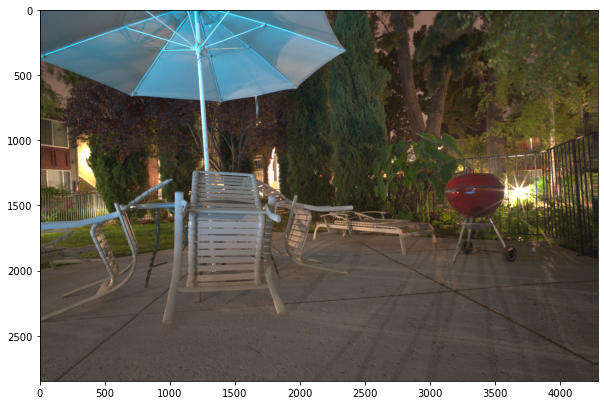

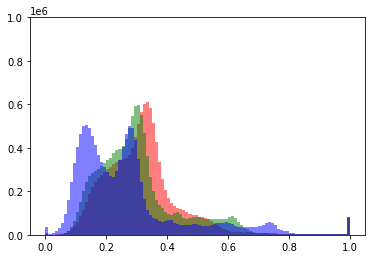

In [ ]:
# Raw data
#print(raw)
plt.figure(figsize=(10,15))
plt.imshow(raw)
plt.show()

# Normalization
raw_norm = np.maximum(raw - 512, 0) / (16383 - 512)  # subtract the black level
#print(raw_norm)
plt.figure(figsize=(10,15))
plt.imshow(raw_norm)
plt.show()

# sRGB
img_norm = RawUtils.bayer2rgb(raw_norm, wb_gain=wb_dcraw, CCM=CCM_dcraw)
#print(img_norm[0,0,:])
plt.figure(figsize=(10,15))
plt.imshow(img_norm)
plt.show()

plt.hist(img_norm[:,:,0].flatten(),bins=100,alpha=0.5,color='r')
plt.hist(img_norm[:,:,1].flatten(),bins=100,alpha=0.5,color='g')
plt.hist(img_norm[:,:,2].flatten(),bins=100,alpha=0.5,color='b')
plt.ylim(0,1e6)
plt.show()

min: 0.0 max: 16383.0


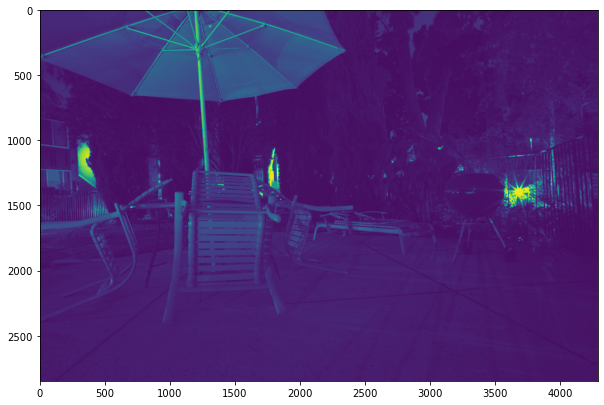

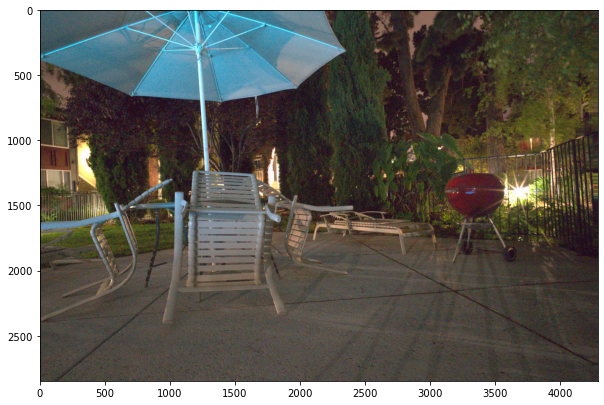

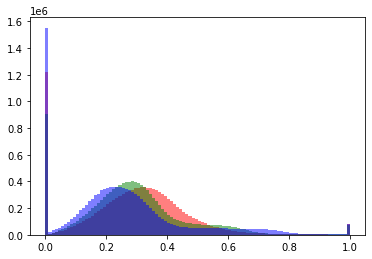

In [ ]:
k = 50
sigma2 = 50

# Add noise
raw_noisy = noise_model(raw, k, sigma2)
#print(raw_noisy[1200:1210,500:503])
print('min:',np.min(raw_noisy),'max:',np.max(raw_noisy))
plt.figure(figsize=(10,15))
plt.imshow(raw_noisy)
plt.show()

raw_noisy_norm = np.maximum(raw_noisy - 512, 0) / (16383 - 512)  # subtract the black level
img_noisy_norm =  RawUtils.bayer2rgb(raw_noisy_norm, wb_gain=wb_dcraw, CCM=CCM_dcraw)
#print(img_noisy_norm[1200:1220,500,:])
plt.figure(figsize=(10,15))
plt.imshow(img_noisy_norm)
plt.show()

plt.hist(img_noisy_norm[:,:,0].flatten(),bins=100,alpha=0.5,color='r')
plt.hist(img_noisy_norm[:,:,1].flatten(),bins=100,alpha=0.5,color='g')
plt.hist(img_noisy_norm[:,:,2].flatten(),bins=100,alpha=0.5,color='b')
plt.show()